# Interpretability using individual conditional expectation

Interpret means to "explain" or to present in understandable terms. The ability to express in understandable terms, what the 
model has learned and the reasons that affect their output.

Interpretability is about the extent to which a cause and effect can be observed within a system. Or to put it another way, it is the extent to which you are able to predict what is going to happen, given a change in input or algorithmic parameters. It's being able to understand which inputs are the most predictive (i.e., impact the prediction/output the most), and anticipate how predictions will change with differing inputs.

* If a customer is rejected a loan, we can say why.
* If an insurance provides a certain premium, we know the reasons.
* If we diagnose a patient with a certain disease, we can tell them why.

In [1]:
# imports
import warnings
warnings.filterwarnings("ignore")

from ucimlrepo import fetch_ucirepo 
import pandas as pd
# pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from alibi.explainers import ALE, plot_ale

from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay

## Load data

In [2]:
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes) 
features = predict_students_dropout_and_academic_success.data.features 
target = predict_students_dropout_and_academic_success.data.targets

# join the features and target
df = pd.concat([features, target], axis=1)
df.head(1)

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout


In [3]:
# divide data into train and test to avoid data snooping bias
train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

In [4]:
train_set['dropout'] = np.where(train_set['Target'] == 'Dropout', 1, 0)
train_set.drop(columns=['Target'], inplace=True)

test_set['dropout'] = np.where(test_set['Target'] == 'Dropout', 1, 0)
test_set.drop(columns=['Target'], inplace=True)

## Preprocessing

Based on what we have seen in exploratory data analysis, we gonna make some transformations in the data to be able to fit them in the random forests model.

In [5]:
qualitative_binary_passthrough = [
    'Tuition fees up to date'
]

# select quantitative features
quantitative_features = [
    'Application order',
    'Age at enrollment',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'GDP'
]

features_to_drop = [
    'Marital Status', 'Application mode',
    'Course', 'Previous qualification',
    'Nacionality', 'Daytime/evening attendance',
    'Displaced', 'Educational special needs',
    'Gender', 'Scholarship holder', 'Debtor',
    'Course', 'Curricular units 1st sem (credited)',
    'Curricular units 2nd sem (credited)',
    'Unemployment rate', 'Inflation rate',
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Curricular units 1st sem (enrolled)',
    'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 1st sem (approved)',
    "Mother's qualification",
    'International'
]

In [6]:
# select only the features that we are going to use
X = train_set.drop(['dropout'], axis=1)
y = train_set['dropout']

In [7]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_delete):
        self.columns_to_delete = columns_to_delete

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_delete, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        return [feat for feat in input_features if feat not in self.columns_to_delete]

In [8]:
drop_features_preproc = make_pipeline(
    DropVariables(features_to_drop))

quantitative_preproc = make_pipeline(
    StandardScaler())

preprocessor = ColumnTransformer([
    ('quantitative_preproc', quantitative_preproc, quantitative_features),
    ('features_to_drop', drop_features_preproc, features_to_drop)],
    remainder='passthrough')

## Train machine learning model

In [9]:
# baseline that predicts only the majority class
baseline = 1 - y.mean()
baseline

0.6851063829787234

In [10]:
def run_classifier_models(X, y, cv, scoring):
    '''Function that trains the following machine learning models:
    RandomForestClassifier, DecisionTreeClassifier, SGDClassifier, SVC,
    LGBMClassifier, GaussianNB.
    The function applies cross-validation on the dataset and returns the average
    of the selected metric on the training and validation sets.
    The only active metrics are Accuracy and F1 score.
    Experiments with the models are logged with MLflow.
    
    :param X: (dataframe or numpy array) 
    Dataframe or array with the independent variables.
    
    :param y: (series or numpy array)
    Column or array with the dependent variable.
    
    :param cv: (int)
    Determines the cross-validation splitting strategy.
    
    :param scoring: (str)
    Strategy to evaluate the model's performance on the validation set during cross-validation.
    Should be passed within quotes when calling the function.
    '''
    # Instantiate the models
    rf = Pipeline(
        steps=[('preprocessor', preprocessor), 
               ('rf', RandomForestClassifier(n_estimators=10, random_state=42))]
    )
    scores = cross_validate(rf, X, y, return_train_score=True,
                            scoring=scoring, cv=cv, return_estimator=True)

    # train and validation with accuracy
    if scoring == 'accuracy':
        log_train_acc = np.mean(scores['train_score'])
        log_test_acc = np.mean(scores['test_score'])
        mean_train = log_train_acc.mean()
        mean_test = log_test_acc.mean()
        std_train = log_train_acc.std()
        std_test = log_test_acc.std()

    # train and validation with f1
    if scoring == 'f1':
        log_train_f1 = np.mean(scores['train_score'])
        log_test_f1 = np.mean(scores['test_score'])
        mean_train = log_train_f1.mean()
        mean_test = log_test_f1.mean()
        std_train = log_train_f1.std()
        std_test = log_test_f1.std()

    # Create final dataset
    df_result = pd.DataFrame(
        {'MEAN_TRAIN_SCORES': mean_train, 
         'MEAN_TEST_SCORES': mean_test, 'STD_TRAIN_SCORES': std_train, 
         'STD_TEST_SCORES': std_test}, index=[0])

    return df_result

In [11]:
# Run classifiers
df_result = run_classifier_models(X, y, 5, 'accuracy')
df_result

,MEAN_TRAIN_SCORES,MEAN_TEST_SCORES,STD_TRAIN_SCORES,STD_TEST_SCORES
0,0.978391,0.851596,0.0,0.0


We have a bit of overfitting but the model seems to perform well.

## Hyperparameter tuning

In [12]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('rf', RandomForestClassifier(n_estimators=10, random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'rf__max_depth': [1, 2, 3, 4],
    # 'dt__max_features': [1, 2, 3, 4, 5, 6, 7, 8, None],
    'rf__max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
} # you should try as many values as possible, but to illustrate we gonna put a heavy weight

# 3. Training and apply grid search with cross validation
grid_search = GridSearchCV(final_model, param_grid, cv = 5, scoring = 'accuracy',
                           return_train_score = True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'rf__max_depth': 4, 'rf__max_leaf_nodes': None}


In [13]:
cvres = grid_search.cv_results_
cvres = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres['mean_test_score'],
                                        cvres['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres[0])

The mean test score and mean train score is, respectively: (0.8654255319148936, 0.8697473404255319)


We drastically reduced overfitting.

# Evaluate new model in test set

In [14]:
# select only the features that we are going to use
X_test = test_set.drop(['dropout'], axis=1)
y_test = test_set['dropout']

In [15]:
# Evaluate final model
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       427
           1       0.84      0.65      0.74       237

    accuracy                           0.83       664
   macro avg       0.84      0.79      0.81       664
weighted avg       0.83      0.83      0.83       664



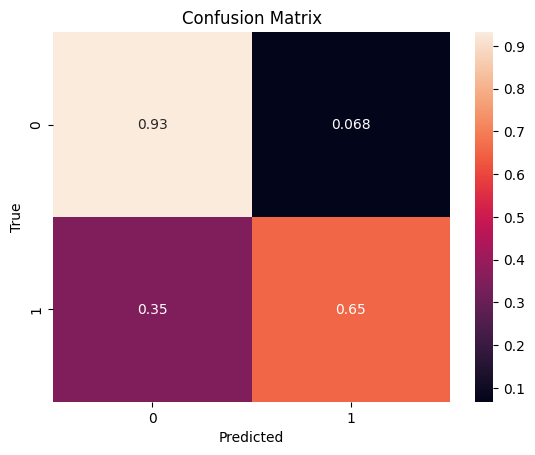

AUC: 0.7930



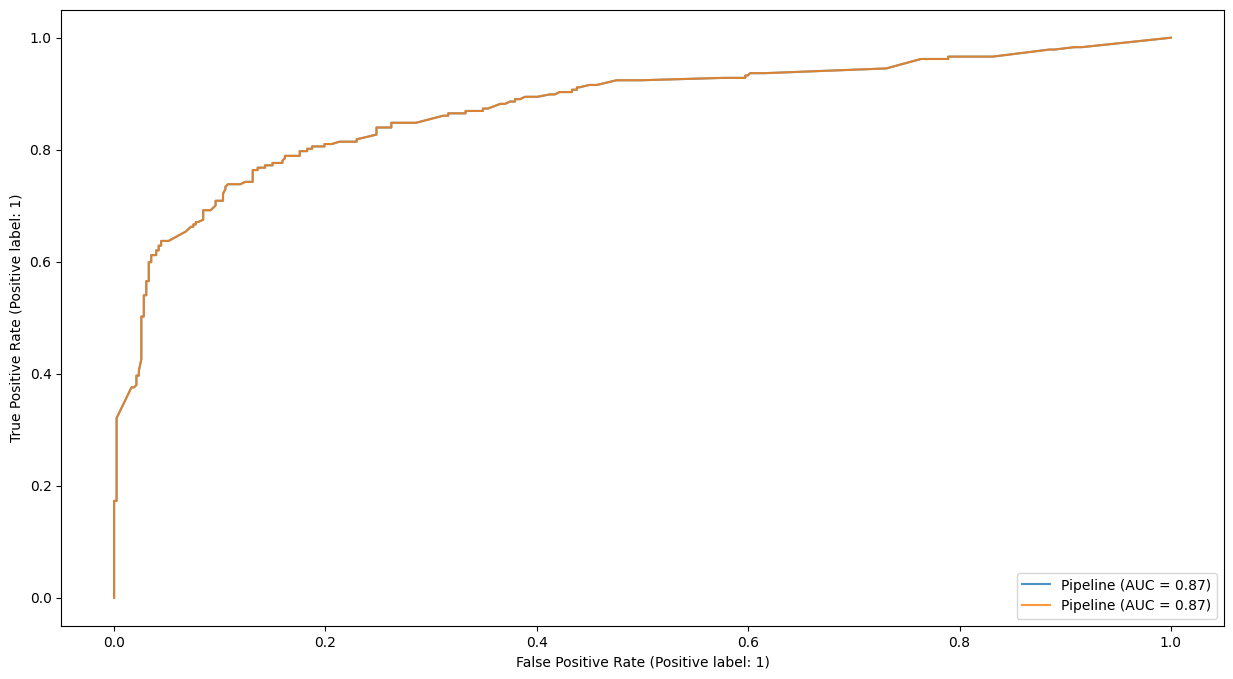

In [16]:
# print classification report
print(classification_report(y_test, final_predictions))

# plot confusion matrix
fig , ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, final_predictions, normalize='true'), annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")
plt.show()

# print and plot roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, final_predictions)))

plt.figure(figsize=(15, 8))
ax = plt.gca()
lgbm_disp = RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax, alpha=0.8)
lgbm_disp.plot(ax=ax, alpha=0.8)
plt.show()

## Individual conditional expectation

Individual conditional expectation are in essence a disaggregation of partial dependence plots. We mentioned that partial dependence plots plot the average prediction for given values of a variable. If you want to get deep in this method, follow the [link](https://github.com/vitorbeltrao/ml-interpretability/blob/main/partial_dependence_plots.ipynb).

So instead of plotting the average prediction, we would just plot how the prediction as we change the values of the variable that we're interested in understanding for each single observation. Each line that you see in the plot is one row of the dataframe. It's also a post-hoc tool.

**Mechanism**

Take the training dataset -> train machine learning model -> understand how the values of the features drive the predictions of this model.

In this method, we add more detail to the influence or the effect of the variable. Because as we plot all the observations instead of just the average, first of all we have a measure of the dispersion and also we could discover pontential interactions.

In fact, it is common practice to plot the ICE and then overlay on top the partial dependence. So, in a nutshell, ICE gives us more information about the relantionship or the influence of the feature we are examining on the prediction of the model.

When we have a lot of observations, it might be difficult to understand or discern visually what is going on. So it is also common practive to cernter the values of the individual conditional expectation at the origin. So, we would center all the initial values of the predictions at zero and then readjust the individual conditional expectation so that we are better able to compare the changes respect to the original value.

### Global Interpretation - Tree derived

In [17]:
# Get the best estimator from the grid search
rf = grid_search.best_estimator_.named_steps['rf']

# importance based on each tree
# Let's take the importance derived by each single decisiont tree
global_exp = pd.DataFrame()

for i in range(10):  # Assuming there are 10 trees in your forest, adjust as needed
    # Get the feature importances of the i-th tree and add them to the DataFrame
    global_exp[f'tree_{i+1}'] = rf.estimators_[i].feature_importances_

# Set the feature names as indices of the DataFrame
global_exp.index = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Calculate the mean importance of features across all trees
global_exp['importance'] = global_exp.mean(axis=1)
global_exp

,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9,tree_10,importance
quantitative_preproc__Application order,0.000000,0.000104,0.015544,0.000296,0.000000,0.000000,0.003779,0.000000,0.000000,0.005998,0.002572
quantitative_preproc__Age at enrollment,0.000000,0.033566,0.003201,0.004850,0.084459,0.251491,0.022831,0.022214,0.199777,0.047037,0.066943
quantitative_preproc__Curricular units 1st sem (evaluations),0.193456,0.245374,0.009474,0.018246,0.006375,0.019959,0.031264,0.004779,0.062287,0.000000,0.059121
quantitative_preproc__Curricular units 1st sem (without evaluations),0.000000,0.000000,0.000000,0.000000,0.003579,0.011825,0.006042,0.000000,0.000000,0.000000,0.002144
quantitative_preproc__Curricular units 2nd sem (enrolled),0.118291,0.000168,0.064317,0.083994,0.000000,0.033853,0.007626,0.081143,0.019511,0.005009,0.041391
quantitative_preproc__Curricular units 2nd sem (approved),0.246906,0.246604,0.060911,0.759980,0.137113,0.433670,0.822476,0.574799,0.402962,0.108526,0.379395
quantitative_preproc__Curricular units 2nd sem (grade),0.419317,0.449737,0.671007,0.002057,0.716361,0.021922,0.028025,0.018876,0.203184,0.655755,0.318624
quantitative_preproc__GDP,0.015768,0.000000,0.002925,0.004159,0.000000,0.009079,0.019080,0.012271,0.000477,0.008600,0.007236
remainder__Tuition fees up to date,0.006262,0.024447,0.172621,0.126418,0.052113,0.218201,0.058877,0.285918,0.111802,0.169075,0.122574


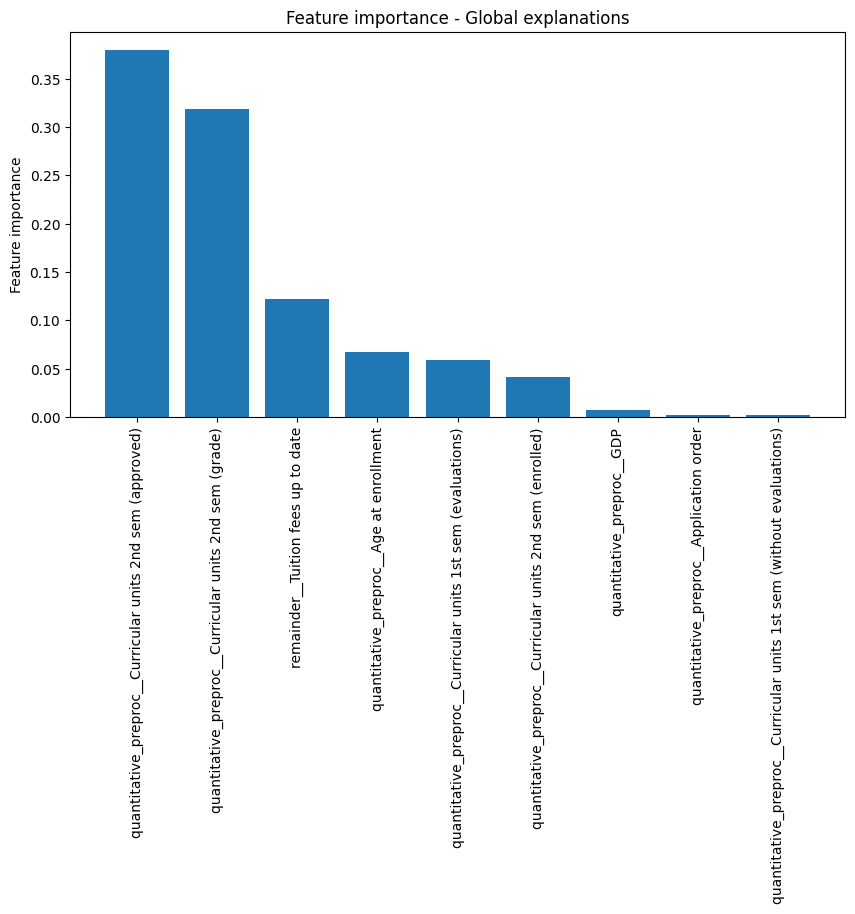

In [18]:
# Sort the DataFrame by the 'importance' column in descending order and plot it
global_exp_sorted = global_exp.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.bar(global_exp_sorted.index, global_exp_sorted['importance'])
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

### Global Interpretation - Individual conditional expectation plots

In ICE plots it might not be easy to see the average effect of the input feature of interest. Hence, it is recommended to use ICE plots alongside PDPs.

In [19]:
X_test_pdp = X_test[[
    'Application order',
    'Age at enrollment',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'GDP', 
    'Tuition fees up to date']]

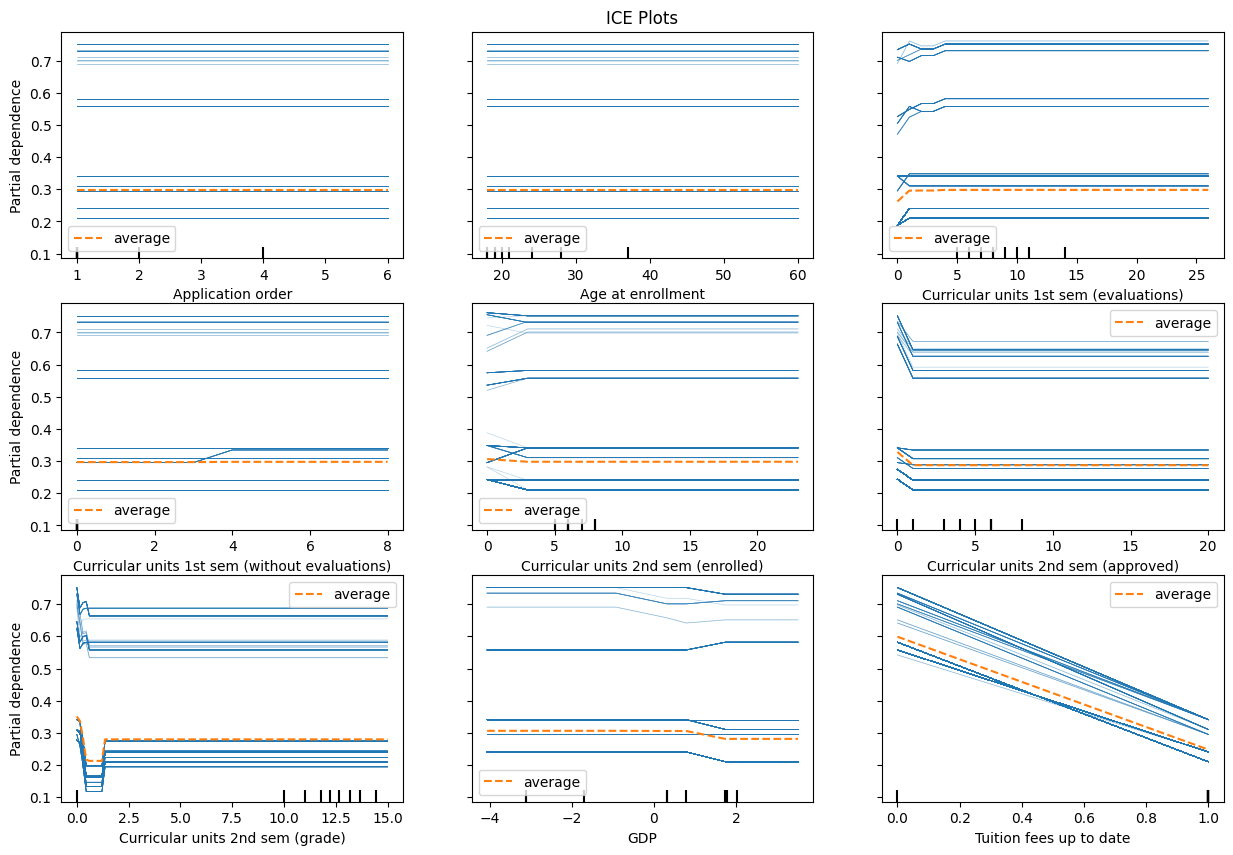

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("ICE Plots")

PartialDependenceDisplay.from_estimator(
    estimator=rf,
    X=X_test_pdp,
    features=[0, 1, 2, 3, 4, 5, 6, 7, 8],  # the features to plot
    kind="both",
    random_state=42,
    ax=ax,
)

plt.show()

Compared to the feature importance that the random forest gives us, some things are a little divergent, but overall, they seem to corroborate each other.

The chance of a student dropping out of the course decreases with an increase in variables: 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'GDP'. 
But at some point, even with an increase in these variables, the chance of a student leaving the course remains constant.

Regarding the categorical variable 'Tuition fees up to date'. If a student is up to date with their fees, this makes their chances of leaving the course also reduced.

The rest of the variables don't tell us much, as they are practically constant at all times.

## Conclusion

So we discussed what ICE plots are and how they provide more information than partial dependence plots.

**Advantages**

* Post-hoc interpretability method. Used after training the machine learning model.
* Local interpretation. Analysis the relationship between feature and target for each observation (they are global as well).
* Model agnostic. Especially useful for opaque estimators.
* ICE, like PDP, accurately represent how the feature influences the prediction when features are not correlated.
* ICE, unlike PDP, can help us unmask interactions or heterogeneous relationships.

**Limitations**

* When features are correlated, the interpretation of ICE is tricky.
* Can realistically be used to examine a handful of features.
* It does not scale.
* It does not output an "importance" value.
* If we plot too many observations it becomes harder to analyze.

**Credits**

https://www.trainindata.com/